# Imports and Loading Data

In [1]:
!pip install -r ../../requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import numpy as np
import pandas as pd
import polars as pl
import datetime
import polars_ols # needed to do rolling OLS calculation
from matplotlib import pyplot as plt
from mpl_bsic import apply_bsic_logo, apply_bsic_style, export_figure, add_title_subtitle


fonts already added so will not add again


In [3]:
bond_data = pl.read_parquet('../../data/final_data/data_with_signals_all.pq')
bond_data.head()

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,intcov_ratio,cash_ratio,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,spread_duration,bucket,dxs,weighted_dxs_median,weighted_ret_median,relative_dxs,systematic_return,residual_return_t+1,oas_delta,oas_quantile,carry_signal_value,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,price_mom_12mo_delta,price_mom_12mo_quantile,credit_momentum_signal_value,ESP_bucket_mean_oas,ESP,esp_residual,esp_residual_delta,esp_residual_quantile,esp_signal_value,eq_mom_6mo,eq_mom_12mo,eq_mom_12mo_delta,eq_mom_12mo_quantile,equity_momentum_signal_value
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,date,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,i64,f64
583213,2012-05-31,"""00037BAA0""",0.006186,0.007551,0.007479,0.006186,null,null,null,6.0,0.010429,null,0.016813,500000.0,500000.0,99.829504,0.998295,60.1,4.723592,11.0,3612,0.004055,0.003489,null,16.0,1.0,1.0,0.017072,0.010567,99.6121,99.715921,25.124045,null,4.9914752e7,4.980605e7,1.625,…,null,null,-0.129911,null,null,-0.004386,0.009923,2.787959,"""2_A_shortdur""",0.027666,0.004472,0.000579,6.186698,0.003583,0.002603,0.001853,8,0.479109,null,null,null,null,null,null,null,null,0.008071,0.001853,null,null,null,null,NaN,NaN,null,null,null
588586,2012-06-30,"""00037BAA0""",0.011728,0.003808,0.004315,0.011728,0.006186,0.006186,0.007479,6.0,0.00888,null,0.015781,500000.0,500000.0,100.447,1.00447,59.1,4.645004,11.0,3612,0.005945,0.014093,null,15.0,1.0,1.0,0.015094,0.008109,100.5391,100.764793,24.445752,null,5.02235e7,5.026955e7,1.625,…,null,null,0.03226,null,null,0.007169,0.00803,2.363495,"""2_A_shortdur""",0.018979,0.004472,0.000579,4.244065,0.002458,0.00927,0.000939,7,0.356791,0.005302,null,null,null,null,null,null,null,0.007091,0.000939,null,null,null,null,NaN,NaN,null,null,null
594002,2012-07-31,"""00037BAA0""",-0.001191,-0.002055,-0.001935,-0.001091,0.011728,0.011728,0.004315,6.0,0.00808,null,0.013519,500000.0,500000.0,101.625066,1.016251,58.066667,4.567047,11.0,3612,0.007198,0.019627,null,15.0,1.0,1.0,0.01264,0.00672,101.665,102.03965,23.628646,null,5.0812533e7,5.08325e7,1.625,…,null,null,0.063111,null,null,-0.007437,0.007105,2.400071,"""2_A_shortdur""",0.017051,0.004472,0.000579,3.813058,0.002208,-0.003299,0.000514,7,0.356791,0.00289,null,null,null,null,null,null,null,0.006591,0.000514,null,null,null,null,NaN,NaN,null,null,null
599442,2012-08-31,"""00037BAA0""",0.002185,0.002064,0.002085,0.002285,-0.001091,-0.001191,-0.001935,6.0,0.008651,null,0.014018,500000.0,500000.0,101.5142,1.015142,57.033333,4.481314,11.0,3612,-0.002496,-0.003326,null,18.0,1.0,1.0,0.012993,0.007078,101.473,101.996612,22.750908,null,5.07571e7,5.07365e7,1.625,…,null,null,-0.001732,null,null,0.00195,0.007447,2.380807,"""2_A_shortdur""",0.017731,0.004472,0.000579,3.964976,0.002296,-0.000011,0.000918,7,0.356791,-0.000224,null,null,null,null,null,null,null,0.006529,0.000918,null,null,null,null,NaN,NaN,null,null,null
604916,2012-09-30,"""00037BAA0""",0.001884,0.005208,0.004934,0.001984,0.002285,0.002185,0.002085,6.0,0.008276,null,0.01376,500000.0,500000.0,101.746142,1.017461,56.033333,4.400393,11.0,3612,0.003524,0.005008,null,15.0,1.0,1.0,0.012316,0.006696,101.7547,102.400185,22.069816,null,5.0873071e7,5.087735e7,1.625,…,null,null,0.079677,null,null,-0.002976,0.006749,2.1584,"""2_A_shortdur""",0.014568,0.004472,0.000579,3.257695,0.001887,0.000097,0.001135,7,0.356791,0.002127,null,null,null,null,null,null,null,0.005614,0.001135,null,null,null,null,NaN,NaN,null,null,null


# Create the Backtester class

In [4]:
class Backtester:
    def __init__(
        self,
        bond_data: pl.DataFrame, 
        half_life: int, 
        formation_end_date: datetime.date, 
        avg_bid_ask: float,
        benchmark_path: str,
        return_col: str = 'bond_ret_t+1'
    ) -> None:
        """Initialize the backtester.
        
        Parameters
        ----------
        bond_data: bond prices data
        half_life: used for signal weighting. Measurement unit is months. E.g. half_life=12 is 12 months. 
        formation_end_date: end date for the formation period, where we let the signal weights converge to their long run mean. 
            This is to make sure that the subsequent changes are due to signal timing, and not just reversion to the mean. 
        avg_bid_ask: avg bid ask spread, as a proxy for transaction costs. We recognize this is *not* a robust estimate for transaction costs, 
            which especially in the case of credit would demand a model. However, this is out of scope for the article. Unit of measurement is %.
        benchmark_path: path to the Excel file containing the benchmark data.
        return_col: return column to use (to use the absolute return, or return over a duration-matched Treasury portfolio). 
        """
        
        self.bond_data = bond_data.sort(['cusip', 'date'])   # DataFrame with time series of alpha estimates for each bond   
        self.signals = [f'{signal_name}_signal_value' for signal_name in ['equity_momentum', 'carry', 'credit_momentum', 'esp']]
        self.return_col = return_col
        
        self.formation_end_date = formation_end_date
        self.avg_bid_ask = avg_bid_ask
        self.half_life = half_life
        self.alpha = 1 - np.exp(-np.log(2) / self.half_life) # compute alpha from the half_life (used for signal weighting)   
        self.benchmark_path = benchmark_path
        
        self.dates = bond_data.select('date').sort('date').unique()
        
    def _load_benchmark(self, returns_index: pd.Index): 
        """Load the benchmark data from the Excel file."""
        
        benchmark = pd.read_excel(self.benchmark_path)
        benchmark = benchmark.rename(columns={column: column.lower() for column in benchmark.columns})
        benchmark = benchmark.set_index('date').reindex(returns_index)
        benchmark['benchmark_cumret'] = benchmark['change'].add(1).cumprod()
        
        return benchmark
        
    def _compute_partial_returns(self, to_date: datetime.date):
        """Compute the partial returns of the signals. For a detailed explanation, refer to the article."""
        data = self.bond_data.filter(pl.col('date') < to_date)
        signals = self.signals
        signals_cols = [pl.col(signal) for signal in signals]
        
        # perform the rolling OLS
        partial_returns = data.select(
            pl.col('date'),
            pl
            .col('residual_return_t+1')
            .least_squares.ols(*signals_cols, add_intercept=False, mode='coefficients', null_policy='drop')
            .over('date')
        ).unnest('coefficients')
        
        return partial_returns
    
    def compute_signal_weights(self) -> pl.DataFrame:
        """Compute the signal weights at each point in time. For a detailed explanation of the procedure, refer to the article."""
        
        # initialize variables
        alpha = self.alpha
        signals = self.signals
        formation_date = self.formation_end_date
        # print(f'using alpha={alpha}')
        
        # compute partial returns during the formation period
        partial_returns_formation_period = self._compute_partial_returns(formation_date)
        
        # calculate partial return volatility
        dates = self.bond_data.filter(pl.col('date') >= formation_date).get_column('date').unique()
        v_0 = partial_returns_formation_period.drop('date').std() # compute volatility at time 0 as a starting point
        
        # initialize two matrices where we will store 
        #   the partial returns volatility and the final signal weights.
        #   the matrices should have rows equal to the number of dates, and one column for each signal
        pr_volatilities = np.zeros((len(dates), len(self.signals)))
        signal_weights = np.zeros((len(dates), len(self.signals)))
                                  
        pr_volatilities[0] = v_0.to_numpy()[0]  # initialize with the volatility from the formation period

        partial_returns_t_0 = partial_returns_formation_period.drop('date')[-1].to_numpy()[0]
        # initialize with equal weights
        signal_weights[0] = partial_returns_t_0 / np.sum(partial_returns_t_0)
        
        j = 0 # logging the status of the code
        # signal weighting at time t depends on the weights at time t-1, so we have to use a for loop
        for i in range(1,len(dates)):
            j += 1
            if j % 50 == 0: 
                print(f'j={j}, {j/len(dates)*100:.2f}%')
            date = dates[i]
            
            # compute the partial returns, and take the last row
            partial_rets = self._compute_partial_returns(date)
            r_t = partial_rets.drop('date')[-1].to_numpy()[0]
            
            # compute volatilities and weights as explained in the article
            pr_volatilities[i] = (1-alpha) * pr_volatilities[i-1] + alpha * np.power(r_t, 2)
            signal_weights[i] = (1-alpha) * signal_weights[i-1] + alpha * r_t / pr_volatilities[i]
            
        # normalize all weights so that they sum up to 1, and the composite signal is consistent
        signal_weights = signal_weights / signal_weights.sum(axis=1).reshape(-1,1)
        signal_weights = (pl.DataFrame(signal_weights)
            .rename({f'column_{i}': signals[i] for i in range(len(signals))})
            .with_columns(
                date=dates
            ))
        
        # rename columns to weights
        signal_weights = signal_weights.rename({col: col.replace('value', 'weight') for col in signals})
            
        return signal_weights
       
    def compute_alpha_estimates(self):
        """Compute the composite signal"""
        bond_data, formation_date, signals = self.bond_data, self.formation_end_date ,self.signals
        signal_weights = self.compute_signal_weights()
        
        # only use the data after the formation period
        df = bond_data.filter(pl.col('date') >= formation_date).join(
            signal_weights,
            how='left',
            on='date'
        )
        
        # exclude the rows where a signal is Null
        condition = pl.any_horizontal(pl.col(*signals).is_null())
        
        # compute the weighted sum of the signal values to get to the final signal estimate
        df = df.with_columns(
            composite_signal=pl.when(condition).then(None).otherwise(pl.col('carry_signal_weight') * pl.col('carry_signal_value') + pl.col('credit_momentum_signal_weight') * pl.col('credit_momentum_signal_value') + pl.col('esp_signal_weight') * pl.col('esp_signal_value') + pl.col('equity_momentum_signal_weight') * pl.col('equity_momentum_signal_value')
            )
        )
        
        return df
    
    def compute_quantiles(self, df: pl.DataFrame, col: str, n_quantiles: int):
        """Divide the composite signal into quantiles to decide positions at each period. Logic is the same as the one used in eval_signal.ipynb"""
        quantile_col_name = f'{col}_quantile'
        
        # create the bins and labels to be used in qcut
        bins = np.linspace(0,1,n_quantiles+1)[1:]
        labels = [str(i+1) for i in range(n_quantiles+1)]
        
        data = []
        for group in df.select('date').unique().iter_rows():
            date = group[0]
            
            group_data = df.filter((pl.col('date') == date) & (pl.col(col).is_not_null())).select('cusip', 'date', col)
    
            # if the DataFrame is emtpy just continue, otherwise qcut will throw an error
            if group_data.shape[0] == 0:
                continue
            
            group_data = group_data.with_columns(
                pl.col(col).qcut(bins,labels=labels, allow_duplicates=True).alias(quantile_col_name)
            )
                
            data.append(group_data)
            
        print('... done!')
        
        quantiles = pl.concat(data, how='vertical')
        quantiles = quantiles.with_columns(
            pl.col(quantile_col_name).cast(int).alias(quantile_col_name)
        )
        return df.join(quantiles.drop('bucket'), how='left', on=['date', 'cusip'])
    
    def get_portfolio_weights(
            self, 
            cusips: list[str], 
            date: datetime.date
    ):
        """Get the portfolio weights for each position. 
        We make a simplifying assumption and use equal weighting. 
        Obviously, it would be better to use MVPO, using the alpha estimates as the expected returns, in order to construct the portfolio.
        """
        
        bonds_data = self.bond_data.filter((pl.col('cusip').is_in(cusips)) & (pl.col('date') <= date))
        
        return bonds_data.with_columns(
            weight=(1/pl.col('cusip').n_unique())
        ).select('cusip', 'weight')
    
    def run(
        self,
    ):
        """Run the backtest. Returns the strategy returns, together with the returns from the benchmark for the same period"""
        
        # get the data needed for the backtest
        bond_data, formation_end_date, avg_bid_ask = self.bond_data, self.formation_end_date, self.avg_bid_ask
        return_col = self.return_col
        alpha_estimates = self.compute_alpha_estimates()
        quantiles = self.compute_quantiles(alpha_estimates, 'composite_signal', 10)
        
        # initialize list of cusips at each period to keep track of portfolio turnover (to estimate transaction costs)
        new_cusips= np.zeros(alpha_estimates.shape[0])
        past_cusips = []
        i=0
        
        # initialize dataframe with portfolio weights
        portfolio_weights = pd.DataFrame(
            columns=quantiles.get_column('cusip').unique()
        )
        
        # run the backtest for each date after the formation period
        for date in quantiles.sort('date').select('date').unique().iter_rows(): 
            i = i+1
            date = date[0] # iter_rows() returns a tuple
            data = quantiles.filter(pl.col('date') == date) # get the bond data for that date
            
            # we go long the top 25 bonds in the 10th decile
            bonds = data.filter(pl.col('composite_signal_quantile') == 10) 
            bonds = bonds.sort('composite_signal_quantile')
            # pick the top 25 bonds
            cusips = bonds[:25].get_column('cusip').unique().to_list()
            new_cusips[i]  = len(set(cusips)-set(past_cusips))
            past_cusips = cusips
            
            # get portfolio weights for the chosen CUSIPs
            weights = self.get_portfolio_weights(cusips, date)
            
            # set the resulting portfolio weights in the DataFrame
            for row in weights.iter_rows(named=True):
                cusip = row['cusip']
                weight = row['weight']
                
                portfolio_weights.loc[date, cusip] = weight
                
        # compute portfolio asset_returns
        asset_returns = bond_data.select('cusip', 'date', return_col).to_pandas()
        asset_returns = (asset_returns
                        # pivot to have a DataFrame which has the dates on the index and one column for each cusip. Cell values are the returns at t+1
                         .pivot(index='date', columns='cusip', values=return_col) 
                         .reindex(portfolio_weights.columns, axis=1) # to make sure the two dataframes are aligned
                         )
           
        # weight bond returns by the portfolio weights
        portfolio_returns = (asset_returns * portfolio_weights).sum(axis=1)
        # only consider returns after the formation date
        portfolio_returns = portfolio_returns[portfolio_returns.index >= pd.to_datetime(formation_end_date)] 
        
        # consider the transaction costs in the returns
        post_tc_cumulative_return = np.zeros(len(portfolio_returns))
        post_tc_cumulative_return[0] = 1 

        for i in range (1, len(portfolio_returns)):
            # apply the avg_bidask_spread each time cusips change
            post_tc_cumulative_return[i] = post_tc_cumulative_return[i - 1] * (1 - new_cusips[i - 1] / 25 * avg_bid_ask) * (1 + portfolio_returns[i - 1])
            
        # group everything into a DataFrame
        strategy_returns = pd.DataFrame(portfolio_returns, columns=['ex_tc_ret'])
        
        # add benchmark returns
        benchmark = self._load_benchmark(strategy_returns.index)
        strategy_returns = strategy_returns.join(benchmark['benchmark_cumret'], how='left')
        
        strategy_returns['ex_tc_cumret'] = strategy_returns['ex_tc_ret'].add(1).cumprod()
        strategy_returns['post_tc_cumret'] = post_tc_cumulative_return
        
        return strategy_returns

In [5]:
bond_data.head(1)

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,intcov_ratio,cash_ratio,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,spread_duration,bucket,dxs,weighted_dxs_median,weighted_ret_median,relative_dxs,systematic_return,residual_return_t+1,oas_delta,oas_quantile,carry_signal_value,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,price_mom_12mo_delta,price_mom_12mo_quantile,credit_momentum_signal_value,ESP_bucket_mean_oas,ESP,esp_residual,esp_residual_delta,esp_residual_quantile,esp_signal_value,eq_mom_6mo,eq_mom_12mo,eq_mom_12mo_delta,eq_mom_12mo_quantile,equity_momentum_signal_value
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,date,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,i64,f64
583213,2012-05-31,"""00037BAA0""",0.006186,0.007551,0.007479,0.006186,null,null,null,6.0,0.010429,null,0.016813,500000.0,500000.0,99.829504,0.998295,60.1,4.723592,11.0,3612,0.004055,0.003489,null,16.0,1.0,1.0,0.017072,0.010567,99.6121,99.715921,25.124045,null,4.9914752e7,4.980605e7,1.625,…,null,null,-0.129911,null,null,-0.004386,0.009923,2.787959,"""2_A_shortdur""",0.027666,0.004472,0.000579,6.186698,0.003583,0.002603,0.001853,8,0.479109,null,null,null,null,null,null,null,null,0.008071,0.001853,null,null,null,null,NaN,NaN,null,null,null


# Run the Backtest

In [8]:
# shared constants
FORMATION_END_DATE = datetime.date(2006,1,1) # 3.5 years of formation period
BID_ASK_SPREAD = 0.004 # 40bps
HALF_LIFE = 12 # 12 months
BENCHMARK_PATH = '../../data/indices/barclays_aggregate_global.xlsx'

## Absolute Returns

In [9]:
RETURN_COL = 'bond_ret_t+1' # compute absolute returns
backtest_absolute_returns = Backtester(bond_data, HALF_LIFE, FORMATION_END_DATE, BID_ASK_SPREAD, BENCHMARK_PATH, RETURN_COL)

strategy_absolute_returns = backtest_absolute_returns.run()

j=50, 24.88%
j=100, 49.75%
j=150, 74.63%
j=200, 99.50%
... done!


sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
C:\Users\andre\AppData\Local\Temp\ipykernel_275424\1296611148.py:256: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  post_tc_cumulative_return[i] = post_tc_cumulative_return[i - 1] * (1 - new_cusips[i - 1] / 25 * avg_bid_ask) * (1 + portfolio_returns[i - 1])


In [10]:
strategy_absolute_returns.head()

,ex_tc_ret,benchmark_cumret,ex_tc_cumret,post_tc_cumret
2006-01-31,0.010838,1.000057,1.010838,1.000000
2006-02-28,0.003542,1.003376,1.014419,1.010838
2006-03-31,-0.003398,0.993530,1.010971,1.010361
2006-04-30,0.004387,0.991729,1.015406,1.003705
2006-05-31,-0.001191,0.990671,1.014196,1.005044


## Returns by hedging the Interest Rate risk

In [11]:
RETURN_COL = 'exretnc_dur_t+1' # compute absolute returns
backtest_hedged_returns = Backtester(bond_data, HALF_LIFE, FORMATION_END_DATE, BID_ASK_SPREAD, BENCHMARK_PATH, RETURN_COL)

strategy_hedged_returns = backtest_hedged_returns.run()

j=50, 24.88%
j=100, 49.75%
j=150, 74.63%
j=200, 99.50%
... done!


sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
C:\Users\andre\AppData\Local\Temp\ipykernel_275424\1296611148.py:256: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  post_tc_cumulative_return[i] = post_tc_cumulative_return[i - 1] * (1 - new_cusips[i - 1] / 25 * avg_bid_ask) * (1 + portfolio_returns[i - 1])


## Plotting Returns

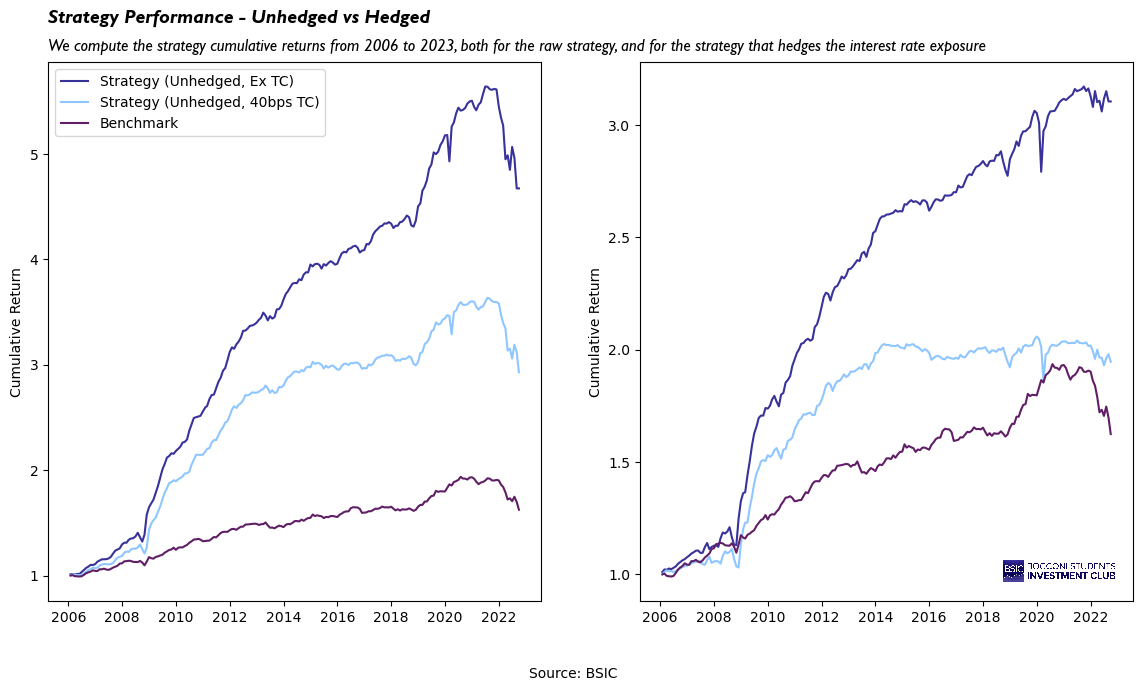

In [17]:
def plot_strategy_returns():
    fig, axs = plt.subplots(1,2, figsize=(14,7))
    plt.style.use('default')
    
    ax1, ax2 = axs[0], axs[1]
    apply_bsic_style(fig)
    
    ax1.plot(strategy_absolute_returns.index, strategy_absolute_returns['ex_tc_cumret'], label='Strategy (Unhedged, Ex TC)')
    ax1.plot(strategy_absolute_returns.index, strategy_absolute_returns['post_tc_cumret'], label='Strategy (Unhedged, 40bps TC)')
    ax2.plot(strategy_hedged_returns.index, strategy_hedged_returns['ex_tc_cumret'], label='Strategy (Hedged, Ex TC)')
    ax2.plot(strategy_hedged_returns.index, strategy_hedged_returns['post_tc_cumret'], label='Strategy (Hedged, 40bps TC)')
    ax1.plot(strategy_absolute_returns.index, strategy_absolute_returns['benchmark_cumret'], label='Benchmark')
    ax2.plot(strategy_absolute_returns.index, strategy_absolute_returns['benchmark_cumret'], label='Benchmark')
    ax1.set_ylabel('Cumulative Return')
    
    ax1.legend()
    apply_bsic_logo(fig, ax2, location='bottom right')
    ax1.set_title('Strategy Performance - Unhedged')
    
    # ax1.plot(returns_hedging_irr.index, returns_hedging_irr['benchmark_cumret'], label='Benchmark')
    ax2.set_title('Strategy Performance - Hedging Interest Rate Exposure')
    ax2.set_ylabel('Cumulative Return')
    
    title = 'Strategy Performance - Unhedged vs Hedged'
    subtitle = 'We compute the strategy cumulative returns from 2006 to 2023, both for the raw strategy, and for the strategy that hedges the interest rate exposure'
    
    add_title_subtitle(fig, title, subtitle, subtitle_bottom_margin=375, title_bottom_margin=395, wrapping_factor=0.85)
    # fig.savefig('strategy_pnl_post.png', dpi=1200, transparent=True, bbox_inches='tight')

plot_strategy_returns()

In [18]:
def rolling_sharpe(strategy_returns: pd.DataFrame): 
    rfr = pd.read_csv('../../data/indices/treasuries_1mo.csv')
    rfr = rfr.rename(columns={col: col.lower() for col in rfr.columns})
    rfr.index = pd.to_datetime(rfr['date'])
    rfr.drop('date', axis=1, inplace=True)
    rfr.columns = ['rfr']
    rfr = rfr.resample('ME').last()
    strategy_returns = strategy_returns.join(rfr.resample('D').last(), how='left')
    
    sharpe = strategy_returns[['post_tc_cumret', 'rfr']]
    sharpe['strategy_ret'] = sharpe['post_tc_cumret'].pct_change()
    sharpe['rfr'] = (sharpe['rfr'] / 100 + 1) ** (1 / 12) - 1
    sharpe['rolling_sharpe'] = (sharpe['strategy_ret'].rolling(24).mean() - sharpe['rfr'].rolling(24).mean()) / sharpe['strategy_ret'].rolling(24).std()
    sharpe['rolling_sharpe_ann'] = sharpe['rolling_sharpe'] * np.sqrt(12)
    
    sharpe_tot = sharpe['post_tc_cumret'].mean() - sharpe['rfr'].mean() / sharpe['post_tc_cumret'].std() * np.sqrt(12) 
    print(f'Total Sharpe is {sharpe_tot}')
    return sharpe


In [20]:
sharpe = rolling_sharpe(strategy_absolute_returns)

Total Sharpe is 2.5494180771461687


C:\Users\andre\AppData\Local\Temp\ipykernel_275424\1568534740.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sharpe['strategy_ret'] = sharpe['post_tc_cumret'].pct_change()
C:\Users\andre\AppData\Local\Temp\ipykernel_275424\1568534740.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sharpe['rfr'] = (sharpe['rfr'] / 100 + 1) ** (1 / 12) - 1
C:\Users\andre\AppData\Local\Temp\ipykernel_275424\1568534740.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
